# Fit logistic regression model

- based on different imputation methods
- baseline: reference
- model: any other selected imputation method

In [1]:
import logging
from pathlib import Path
from typing import List

import matplotlib.pyplot as plt
import njab.sklearn
import pandas as pd
import sklearn
from njab.plotting.metrics import plot_split_auc, plot_split_prc
from njab.sklearn.types import Splits

import pimmslearn
import pimmslearn.analyzers
import pimmslearn.io.datasplits

plt.rcParams['figure.figsize'] = (2.5, 2.5)
plt.rcParams['lines.linewidth'] = 1
plt.rcParams['lines.markersize'] = 2
fontsize = 5
figsize = (2.5, 2.5)
pimmslearn.plotting.make_large_descriptors(fontsize)


logger = pimmslearn.logging.setup_nb_logger()
logging.getLogger('fontTools').setLevel(logging.ERROR)


def parse_roc(*res: List[njab.sklearn.types.Results]) -> pd.DataFrame:
    ret = list()
    for _r in res:
        _roc = (pd.DataFrame(_r.test.roc,
                             index='fpr tpr cutoffs'.split()
                             )).loc[['fpr', 'tpr']]
        _roc = _roc.T
        _roc.columns = pd.MultiIndex.from_product([[_r.name], _roc.columns])
        ret.append(_roc)
    ret = pd.concat(ret, axis=1)
    return ret


def parse_prc(*res: List[njab.sklearn.types.Results]) -> pd.DataFrame:
    ret = list()
    for _r in res:
        _prc = pd.DataFrame(_r.test.prc,
                            index='precision recall cutoffs'.split()
                            ).loc[['precision', 'recall']]
        _prc = _prc.T.rename(columns={'recall': 'tpr'})
        _prc.columns = pd.MultiIndex.from_product([[_r.name], _prc.columns])
        ret.append(_prc)
    ret = pd.concat(ret, axis=1)
    return ret


# catch passed parameters
args = None
args = dict(globals()).keys()

## Parameters
Default and set parameters for the notebook.

In [2]:
folder_data: str = ''  # specify data directory if needed
fn_clinical_data = "data/ALD_study/processed/ald_metadata_cli.csv"
folder_experiment = "runs/appl_ald_data/plasma/proteinGroups"
model_key = 'VAE'
target = 'kleiner'
sample_id_col = 'Sample ID'
cutoff_target: int = 2  # => for binarization target >= cutoff_target
file_format = "csv"
out_folder = 'diff_analysis'
fn_qc_samples = ''  # 'data/ALD_study/processed/qc_plasma_proteinGroups.pkl'

baseline = 'RSN'  # default is RSN, as this was used in the original ALD Niu. et. al 2022
template_pred = 'pred_real_na_{}.csv'  # fixed, do not change

In [3]:
# Parameters
cutoff_target = 0.5
folder_experiment = "runs/alzheimer_study"
target = "AD"
baseline = "PI"
model_key = "DAE"
out_folder = "diff_analysis"
fn_clinical_data = "runs/alzheimer_study/data/clinical_data.csv"


In [4]:
params = pimmslearn.nb.get_params(args, globals=globals())
args = pimmslearn.nb.Config()
args.folder_experiment = Path(params["folder_experiment"])
args = pimmslearn.nb.add_default_paths(args,
                                 out_root=(args.folder_experiment
                                           / params["out_folder"]
                                           / params["target"]
                                           / f"{params['baseline']}_vs_{params['model_key']}"))
args.update_from_dict(params)
files_out = dict()
args

root - INFO     Removed from global namespace: folder_data


root - INFO     Removed from global namespace: fn_clinical_data


root - INFO     Removed from global namespace: folder_experiment


root - INFO     Removed from global namespace: model_key


root - INFO     Removed from global namespace: target


root - INFO     Removed from global namespace: sample_id_col


root - INFO     Removed from global namespace: cutoff_target


root - INFO     Removed from global namespace: file_format


root - INFO     Removed from global namespace: out_folder


root - INFO     Removed from global namespace: fn_qc_samples


root - INFO     Removed from global namespace: baseline


root - INFO     Removed from global namespace: template_pred


root - INFO     Already set attribute: folder_experiment has value runs/alzheimer_study


root - INFO     Already set attribute: out_folder has value diff_analysis


{'baseline': 'PI',
 'cutoff_target': 0.5,
 'data': PosixPath('runs/alzheimer_study/data'),
 'file_format': 'csv',
 'fn_clinical_data': 'runs/alzheimer_study/data/clinical_data.csv',
 'fn_qc_samples': '',
 'folder_data': '',
 'folder_experiment': PosixPath('runs/alzheimer_study'),
 'model_key': 'DAE',
 'out_figures': PosixPath('runs/alzheimer_study/figures'),
 'out_folder': PosixPath('runs/alzheimer_study/diff_analysis/AD/PI_vs_DAE'),
 'out_metrics': PosixPath('runs/alzheimer_study'),
 'out_models': PosixPath('runs/alzheimer_study'),
 'out_preds': PosixPath('runs/alzheimer_study/preds'),
 'sample_id_col': 'Sample ID',
 'target': 'AD',
 'template_pred': 'pred_real_na_{}.csv'}

## Load data

### Load target

In [5]:
target = pd.read_csv(args.fn_clinical_data,
                     index_col=0,
                     usecols=[args.sample_id_col, args.target])
target = target.dropna()
target

,AD
Sample ID,
Sample_000,0
Sample_001,1
Sample_002,1
Sample_003,1
Sample_004,1
...,...
Sample_205,1
Sample_206,0
Sample_207,0


### MS proteomics or specified omics data
Aggregated from data splits of the imputation workflow run before.

In [6]:
data = pimmslearn.io.datasplits.DataSplits.from_folder(
    args.data, file_format=args.file_format)
data = pd.concat([data.train_X, data.val_y, data.test_y])
data.sample(5)

pimmslearn.io.datasplits - INFO     Loaded 'train_X' from file: runs/alzheimer_study/data/train_X.csv


pimmslearn.io.datasplits - INFO     Loaded 'val_y' from file: runs/alzheimer_study/data/val_y.csv


pimmslearn.io.datasplits - INFO     Loaded 'test_y' from file: runs/alzheimer_study/data/test_y.csv


Sample ID   protein groups          
Sample_128  Q9UKU6                     12.321
Sample_061  P40189                     17.765
Sample_162  Q9BY67-2                   18.409
Sample_164  O75882;O75882-2;O75882-3   17.819
Sample_111  A0A087X0D5;P09668          15.878
Name: intensity, dtype: float64

Get overlap between independent features and target

### Select by ALD criteria
Use parameters as specified in [ALD study](https://github.com/RasmussenLab/pimms/tree/main/project/data/ALD_study).

In [7]:
DATA_COMPLETENESS = 0.6
MIN_N_PROTEIN_GROUPS: int = 200
FRAC_PROTEIN_GROUPS: int = 0.622
CV_QC_SAMPLE: float = 0.4

ald_study, cutoffs = pimmslearn.analyzers.diff_analysis.select_raw_data(data.unstack(
), data_completeness=DATA_COMPLETENESS, frac_protein_groups=FRAC_PROTEIN_GROUPS)

if args.fn_qc_samples:
    qc_samples = pd.read_pickle(args.fn_qc_samples)
    qc_samples = qc_samples[ald_study.columns]
    qc_cv_feat = qc_samples.std() / qc_samples.mean()
    qc_cv_feat = qc_cv_feat.rename(qc_samples.columns.name)
    fig, ax = plt.subplots(figsize=(4, 7))
    ax = qc_cv_feat.plot.box(ax=ax)
    ax.set_ylabel('Coefficient of Variation')
    print((qc_cv_feat < CV_QC_SAMPLE).value_counts())
    ald_study = ald_study[pimmslearn.analyzers.diff_analysis.select_feat(qc_samples)]

column_name_first_prot_to_pg = {
    pg.split(';')[0]: pg for pg in data.unstack().columns}

ald_study = ald_study.rename(columns=column_name_first_prot_to_pg)
ald_study

root - INFO     Initally: N samples: 210, M feat: 1421


root - INFO     Dropped features quantified in less than 126 samples.


root - INFO     After feat selection: N samples: 210, M feat: 1213


root - INFO     Min No. of Protein-Groups in single sample: 754


root - INFO     Finally: N samples: 210, M feat: 1213


protein groups,A0A024QZX5;A0A087X1N8;P35237,A0A024R0T9;K7ER74;P02655,A0A024R3W6;A0A024R412;O60462;O60462-2;O60462-3;O60462-4;O60462-5;Q7LBX6;X5D2Q8,A0A024R644;A0A0A0MRU5;A0A1B0GWI2;O75503,A0A075B6H9,A0A075B6I0,A0A075B6I1,A0A075B6I6,A0A075B6I9,A0A075B6J9,...,Q9Y653;Q9Y653-2;Q9Y653-3,Q9Y696,Q9Y6C2,Q9Y6N6,Q9Y6N7;Q9Y6N7-2;Q9Y6N7-4,Q9Y6R7,Q9Y6X5,Q9Y6Y8;Q9Y6Y8-2,Q9Y6Y9,S4R3U6
Sample ID,,,,,,,,,,,,,,,,,,,,,
Sample_000,15.912,16.852,15.570,16.481,20.246,16.764,17.584,16.988,20.054,NaN,...,16.012,15.178,NaN,15.050,16.842,19.863,NaN,19.563,12.837,12.805
Sample_001,15.936,16.874,15.519,16.387,19.941,18.786,17.144,NaN,19.067,16.188,...,15.528,15.576,NaN,14.833,16.597,20.299,15.556,19.386,13.970,12.442
Sample_002,16.111,14.523,15.935,16.416,19.251,16.832,15.671,17.012,18.569,NaN,...,15.229,14.728,13.757,15.118,17.440,19.598,15.735,20.447,12.636,12.505
Sample_003,16.107,17.032,15.802,16.979,19.628,17.852,18.877,14.182,18.985,13.438,...,15.495,14.590,14.682,15.140,17.356,19.429,NaN,20.216,12.627,12.445
Sample_004,15.603,15.331,15.375,16.679,20.450,18.682,17.081,14.140,19.686,14.495,...,14.757,15.094,14.048,15.256,17.075,19.582,15.328,19.867,13.145,12.235
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Sample_205,15.682,16.886,14.910,16.482,17.705,17.039,NaN,16.413,19.102,16.064,...,15.235,15.684,14.236,15.415,17.551,17.922,16.340,19.928,12.929,11.802
Sample_206,15.798,17.554,15.600,15.938,18.154,18.152,16.503,16.860,18.538,15.288,...,15.422,16.106,NaN,15.345,17.084,18.708,14.249,19.433,NaN,NaN
Sample_207,15.739,16.877,15.469,16.898,18.636,17.950,16.321,16.401,18.849,17.580,...,15.808,16.098,14.403,15.715,16.586,18.725,16.138,19.599,13.637,11.174


Number of complete cases which can be used:

In [8]:
mask_has_target = data.index.levels[0].intersection(target.index)
assert not mask_has_target.empty, f"No data for target: {data.index.levels[0]} and {target.index}"
print(
    f"Samples available both in proteomics data and for target: {len(mask_has_target)}")
target, data, ald_study = target.loc[mask_has_target], data.loc[mask_has_target], ald_study.loc[mask_has_target]

Samples available both in proteomics data and for target: 210


### Load imputations from specified model

In [9]:
fname = args.out_preds / args.template_pred.format(args.model_key)
print(f"missing values pred. by {args.model_key}: {fname}")
load_single_csv_pred_file = pimmslearn.analyzers.compare_predictions.load_single_csv_pred_file
pred_real_na = load_single_csv_pred_file(fname).loc[mask_has_target]
pred_real_na.sample(3)

missing values pred. by DAE: runs/alzheimer_study/preds/pred_real_na_DAE.csv


Sample ID   protein groups                 
Sample_023  G3V295;G3V3I1;G3V5Z7;P60900       10.299
Sample_041  Q14956;Q14956-2                   14.879
Sample_203  B1ALD9;Q15063;Q15063-3;Q15063-5   14.916
Name: intensity, dtype: float64

### Load imputations from baseline model

In [10]:
fname = args.out_preds / args.template_pred.format(args.baseline)
pred_real_na_baseline = load_single_csv_pred_file(fname)  # .loc[mask_has_target]
pred_real_na_baseline

Sample ID   protein groups          
Sample_000  A0A075B6J9                 12.197
            A0A075B6Q5                 14.403
            A0A075B6R2                 13.408
            A0A075B6S5                 13.353
            A0A087WSY4                 13.022
                                        ...  
Sample_209  Q9P1W8;Q9P1W8-2;Q9P1W8-4   12.894
            Q9UI40;Q9UI40-2            12.543
            Q9UIW2                     14.842
            Q9UMX0;Q9UMX0-2;Q9UMX0-4   13.462
            Q9UP79                     13.274
Name: intensity, Length: 46401, dtype: float64

## Modeling setup
General approach:
  - use one train, test split of the data
  - select best 10 features from training data `X_train`, `y_train` before binarization of target
  - dichotomize (binarize) data into to groups (zero and 1)
  - evaluate model on the test data `X_test`, `y_test`

Repeat general approach for
 1. all original ald data: all features justed in original ALD study
 2. all model data: all features available my using the self supervised deep learning model
 3. newly available feat only: the subset of features available from the
    self supervised deep learning model which were newly retained using the
    new approach

All data:

In [11]:
X = pd.concat([data, pred_real_na]).unstack()
X

protein groups,A0A024QZX5;A0A087X1N8;P35237,A0A024R0T9;K7ER74;P02655,A0A024R3W6;A0A024R412;O60462;O60462-2;O60462-3;O60462-4;O60462-5;Q7LBX6;X5D2Q8,A0A024R644;A0A0A0MRU5;A0A1B0GWI2;O75503,A0A075B6H7,A0A075B6H9,A0A075B6I0,A0A075B6I1,A0A075B6I6,A0A075B6I9,...,Q9Y653;Q9Y653-2;Q9Y653-3,Q9Y696,Q9Y6C2,Q9Y6N6,Q9Y6N7;Q9Y6N7-2;Q9Y6N7-4,Q9Y6R7,Q9Y6X5,Q9Y6Y8;Q9Y6Y8-2,Q9Y6Y9,S4R3U6
Sample ID,,,,,,,,,,,,,,,,,,,,,
Sample_000,15.912,16.852,15.570,16.481,17.301,20.246,16.764,17.584,16.988,20.054,...,16.012,15.178,14.280,15.050,16.842,19.863,16.072,19.563,12.837,12.805
Sample_001,15.936,16.874,15.519,16.387,13.796,19.941,18.786,17.144,16.546,19.067,...,15.528,15.576,13.704,14.833,16.597,20.299,15.556,19.386,13.970,12.442
Sample_002,16.111,14.523,15.935,16.416,18.175,19.251,16.832,15.671,17.012,18.569,...,15.229,14.728,13.757,15.118,17.440,19.598,15.735,20.447,12.636,12.505
Sample_003,16.107,17.032,15.802,16.979,15.963,19.628,17.852,18.877,14.182,18.985,...,15.495,14.590,14.682,15.140,17.356,19.429,15.953,20.216,12.627,12.445
Sample_004,15.603,15.331,15.375,16.679,15.473,20.450,18.682,17.081,14.140,19.686,...,14.757,15.094,14.048,15.256,17.075,19.582,15.328,19.867,13.145,12.235
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Sample_205,15.682,16.886,14.910,16.482,15.283,17.705,17.039,15.752,16.413,19.102,...,15.235,15.684,14.236,15.415,17.551,17.922,16.340,19.928,12.929,11.802
Sample_206,15.798,17.554,15.600,15.938,15.059,18.154,18.152,16.503,16.860,18.538,...,15.422,16.106,14.914,15.345,17.084,18.708,14.249,19.433,11.857,10.439
Sample_207,15.739,16.877,15.469,16.898,13.545,18.636,17.950,16.321,16.401,18.849,...,15.808,16.098,14.403,15.715,16.586,18.725,16.138,19.599,13.637,11.174


### Subset of data by ALD criteria

In [12]:
# could be just observed, drop columns with missing values
ald_study = pd.concat(
    [ald_study.stack(),
     pred_real_na_baseline.loc[
        # only select columns in selected in ald_study
        pd.IndexSlice[:, pred_real_na.index.levels[-1].intersection(ald_study.columns)]
    ]
    ]
).unstack()
ald_study

protein groups,A0A024QZX5;A0A087X1N8;P35237,A0A024R0T9;K7ER74;P02655,A0A024R3W6;A0A024R412;O60462;O60462-2;O60462-3;O60462-4;O60462-5;Q7LBX6;X5D2Q8,A0A024R644;A0A0A0MRU5;A0A1B0GWI2;O75503,A0A075B6H9,A0A075B6I0,A0A075B6I1,A0A075B6I6,A0A075B6I9,A0A075B6K4,...,O14793,O95479;R4GMU1,P01282;P01282-2,P10619;P10619-2;X6R5C5;X6R8A1,P21810,Q14956;Q14956-2,Q6ZMP0;Q6ZMP0-2,Q9HBW1,Q9NY15,P17050
Sample ID,,,,,,,,,,,,,,,,,,,,,
Sample_000,15.912,16.852,15.570,16.481,20.246,16.764,17.584,16.988,20.054,16.148,...,12.181,12.696,13.055,13.616,13.583,12.719,14.859,12.808,12.578,13.283
Sample_001,15.936,16.874,15.519,16.387,19.941,18.786,17.144,11.800,19.067,16.127,...,12.727,13.386,12.895,13.538,13.228,14.187,13.463,11.852,11.099,13.672
Sample_002,16.111,14.523,15.935,16.416,19.251,16.832,15.671,17.012,18.569,15.387,...,12.006,12.666,12.427,12.828,12.476,11.280,13.527,12.362,13.299,12.694
Sample_003,16.107,17.032,15.802,16.979,19.628,17.852,18.877,14.182,18.985,16.565,...,13.930,12.077,12.851,12.976,12.732,13.149,13.351,11.959,12.866,12.883
Sample_004,15.603,15.331,15.375,16.679,20.450,18.682,17.081,14.140,19.686,16.418,...,11.838,12.914,13.942,14.711,13.290,12.591,11.901,12.726,11.551,13.372
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Sample_205,15.682,16.886,14.910,16.482,17.705,17.039,13.301,16.413,19.102,15.350,...,14.269,14.064,16.826,18.182,15.225,15.044,14.192,16.605,14.995,14.257
Sample_206,15.798,17.554,15.600,15.938,18.154,18.152,16.503,16.860,18.538,16.582,...,14.273,17.700,16.802,20.202,15.280,15.086,13.978,18.086,15.557,14.171
Sample_207,15.739,16.877,15.469,16.898,18.636,17.950,16.321,16.401,18.849,15.768,...,14.473,16.882,16.917,20.105,15.690,15.135,13.138,17.066,15.706,15.690


Features which would not have been included using ALD criteria:

In [13]:
new_features = X.columns.difference(ald_study.columns)
new_features

Index(['A0A075B6H7', 'A0A075B6Q5', 'A0A075B7B8', 'A0A087WSY4',
       'A0A087WTT8;A0A0A0MQX5;O94779;O94779-2', 'A0A087WXB8;Q9Y274',
       'A0A087WXE9;E9PQ70;Q6UXH9;Q6UXH9-2;Q6UXH9-3',
       'A0A087X1Z2;C9JTV4;H0Y4Y4;Q8WYH2;Q96C19;Q9BUP0;Q9BUP0-2',
       'A0A0A0MQS9;A0A0A0MTC7;Q16363;Q16363-2', 'A0A0A0MSN4;P12821;P12821-2',
       ...
       'Q9NZ94;Q9NZ94-2;Q9NZ94-3', 'Q9NZU1', 'Q9P1W8;Q9P1W8-2;Q9P1W8-4',
       'Q9UHI8', 'Q9UI40;Q9UI40-2',
       'Q9UIB8;Q9UIB8-2;Q9UIB8-3;Q9UIB8-4;Q9UIB8-5;Q9UIB8-6',
       'Q9UKZ4;Q9UKZ4-2', 'Q9UMX0;Q9UMX0-2;Q9UMX0-4', 'Q9Y281;Q9Y281-3',
       'Q9Y490'],
      dtype='object', name='protein groups', length=208)

Binarize targets, but also keep groups for stratification

In [14]:
target_to_group = target.copy()
target = target >= args.cutoff_target
pd.crosstab(target.squeeze(), target_to_group.squeeze())

AD,0,1
AD,,
False,122,0
True,0,88


## Determine best number of parameters by cross validation procedure

using subset of data by ALD criteria:

In [15]:
cv_feat_ald = njab.sklearn.find_n_best_features(X=ald_study, y=target, name=args.target,
                                                groups=target_to_group)
cv_feat_ald = (cv_feat_ald
               .drop('test_case', axis=1)
               .groupby('n_features')
               .agg(['mean', 'std']))
cv_feat_ald

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00, 330.47it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

100%|██████████| 2/2 [00:00<00:00,  7.40it/s]

100%|██████████| 2/2 [00:00<00:00,  7.34it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

 67%|██████▋   | 2/3 [00:00<00:00,  3.70it/s]

100%|██████████| 3/3 [00:00<00:00,  3.43it/s]

100%|██████████| 3/3 [00:00<00:00,  3.48it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

 50%|█████     | 2/4 [00:00<00:00,  6.74it/s]

 75%|███████▌  | 3/4 [00:00<00:00,  5.03it/s]

100%|██████████| 4/4 [00:00<00:00,  4.50it/s]

100%|██████████| 4/4 [00:00<00:00,  4.82it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

 40%|████      | 2/5 [00:00<00:00,  7.58it/s]

 60%|██████    | 3/5 [00:00<00:00,  5.52it/s]

 80%|████████  | 4/5 [00:00<00:00,  4.96it/s]

100%|██████████| 5/5 [00:01<00:00,  4.33it/s]

100%|██████████| 5/5 [00:01<00:00,  4.82it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

 33%|███▎      | 2/6 [00:00<00:00,  4.97it/s]

 50%|█████     | 3/6 [00:00<00:00,  3.61it/s]

 67%|██████▋   | 4/6 [00:01<00:00,  3.15it/s]

 83%|████████▎ | 5/6 [00:01<00:00,  3.18it/s]

100%|██████████| 6/6 [00:01<00:00,  3.27it/s]

100%|██████████| 6/6 [00:01<00:00,  3.39it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

 29%|██▊       | 2/7 [00:00<00:00,  9.33it/s]

 43%|████▎     | 3/7 [00:00<00:00,  6.73it/s]

 57%|█████▋    | 4/7 [00:00<00:00,  5.26it/s]

 71%|███████▏  | 5/7 [00:00<00:00,  4.88it/s]

 86%|████████▌ | 6/7 [00:01<00:00,  4.47it/s]

100%|██████████| 7/7 [00:01<00:00,  4.60it/s]

100%|██████████| 7/7 [00:01<00:00,  5.07it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

 25%|██▌       | 2/8 [00:00<00:00,  6.13it/s]

 38%|███▊      | 3/8 [00:00<00:01,  3.91it/s]

 50%|█████     | 4/8 [00:01<00:01,  2.88it/s]

 62%|██████▎   | 5/8 [00:01<00:01,  2.85it/s]

 75%|███████▌  | 6/8 [00:01<00:00,  2.69it/s]

 88%|████████▊ | 7/8 [00:02<00:00,  2.75it/s]

100%|██████████| 8/8 [00:02<00:00,  2.97it/s]

100%|██████████| 8/8 [00:02<00:00,  3.06it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

 22%|██▏       | 2/9 [00:00<00:01,  6.46it/s]

 33%|███▎      | 3/9 [00:00<00:01,  4.27it/s]

 44%|████▍     | 4/9 [00:01<00:01,  3.56it/s]

 56%|█████▌    | 5/9 [00:01<00:01,  3.27it/s]

 67%|██████▋   | 6/9 [00:01<00:00,  3.18it/s]

 78%|███████▊  | 7/9 [00:01<00:00,  3.23it/s]

 89%|████████▉ | 8/9 [00:02<00:00,  3.34it/s]

100%|██████████| 9/9 [00:02<00:00,  3.16it/s]

100%|██████████| 9/9 [00:02<00:00,  3.42it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

 20%|██        | 2/10 [00:00<00:00,  9.26it/s]

 30%|███       | 3/10 [00:00<00:01,  6.61it/s]

 40%|████      | 4/10 [00:00<00:01,  5.72it/s]

 50%|█████     | 5/10 [00:00<00:00,  5.14it/s]

 60%|██████    | 6/10 [00:01<00:00,  4.55it/s]

 70%|███████   | 7/10 [00:01<00:00,  4.73it/s]

 80%|████████  | 8/10 [00:01<00:00,  4.25it/s]

 90%|█████████ | 9/10 [00:01<00:00,  4.41it/s]

100%|██████████| 10/10 [00:02<00:00,  4.61it/s]

100%|██████████| 10/10 [00:02<00:00,  4.93it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

 18%|█▊        | 2/11 [00:00<00:00, 10.07it/s]

 36%|███▋      | 4/11 [00:00<00:01,  5.85it/s]

 45%|████▌     | 5/11 [00:00<00:01,  4.74it/s]

 55%|█████▍    | 6/11 [00:01<00:01,  4.63it/s]

 64%|██████▎   | 7/11 [00:01<00:00,  4.47it/s]

 73%|███████▎  | 8/11 [00:01<00:00,  4.31it/s]

 82%|████████▏ | 9/11 [00:01<00:00,  4.33it/s]

 91%|█████████ | 10/11 [00:02<00:00,  4.31it/s]

100%|██████████| 11/11 [00:02<00:00,  4.40it/s]

100%|██████████| 11/11 [00:02<00:00,  4.69it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

 17%|█▋        | 2/12 [00:00<00:01,  7.04it/s]

 25%|██▌       | 3/12 [00:00<00:01,  5.30it/s]

 33%|███▎      | 4/12 [00:00<00:01,  4.85it/s]

 42%|████▏     | 5/12 [00:00<00:01,  4.95it/s]

 50%|█████     | 6/12 [00:01<00:01,  4.88it/s]

 58%|█████▊    | 7/12 [00:01<00:01,  4.83it/s]

 67%|██████▋   | 8/12 [00:01<00:00,  4.51it/s]

 75%|███████▌  | 9/12 [00:01<00:00,  4.28it/s]

 83%|████████▎ | 10/12 [00:02<00:00,  4.09it/s]

 92%|█████████▏| 11/12 [00:02<00:00,  4.20it/s]

100%|██████████| 12/12 [00:02<00:00,  3.83it/s]

100%|██████████| 12/12 [00:02<00:00,  4.43it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

 15%|█▌        | 2/13 [00:00<00:01,  9.77it/s]

 23%|██▎       | 3/13 [00:00<00:01,  6.80it/s]

 31%|███       | 4/13 [00:00<00:01,  5.72it/s]

 38%|███▊      | 5/13 [00:00<00:01,  5.39it/s]

 46%|████▌     | 6/13 [00:01<00:01,  5.11it/s]

 54%|█████▍    | 7/13 [00:01<00:01,  5.06it/s]

 62%|██████▏   | 8/13 [00:01<00:00,  5.16it/s]

 69%|██████▉   | 9/13 [00:01<00:00,  5.30it/s]

 77%|███████▋  | 10/13 [00:01<00:00,  4.65it/s]

 85%|████████▍ | 11/13 [00:02<00:00,  4.73it/s]

 92%|█████████▏| 12/13 [00:02<00:00,  4.64it/s]

100%|██████████| 13/13 [00:02<00:00,  4.42it/s]

100%|██████████| 13/13 [00:02<00:00,  5.04it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

 14%|█▍        | 2/14 [00:00<00:01,  8.44it/s]

 21%|██▏       | 3/14 [00:00<00:01,  6.07it/s]

 29%|██▊       | 4/14 [00:00<00:01,  5.14it/s]

 36%|███▌      | 5/14 [00:00<00:01,  5.05it/s]

 43%|████▎     | 6/14 [00:01<00:01,  4.64it/s]

 50%|█████     | 7/14 [00:01<00:01,  4.65it/s]

 57%|█████▋    | 8/14 [00:01<00:01,  4.57it/s]

 64%|██████▍   | 9/14 [00:01<00:01,  4.28it/s]

 71%|███████▏  | 10/14 [00:02<00:01,  3.79it/s]

 79%|███████▊  | 11/14 [00:02<00:00,  3.96it/s]

 86%|████████▌ | 12/14 [00:02<00:00,  3.82it/s]

 93%|█████████▎| 13/14 [00:02<00:00,  3.96it/s]

100%|██████████| 14/14 [00:03<00:00,  4.08it/s]

100%|██████████| 14/14 [00:03<00:00,  4.41it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

 13%|█▎        | 2/15 [00:00<00:01,  8.65it/s]

 20%|██        | 3/15 [00:00<00:01,  6.25it/s]

 27%|██▋       | 4/15 [00:00<00:02,  5.31it/s]

 33%|███▎      | 5/15 [00:00<00:02,  4.78it/s]

 40%|████      | 6/15 [00:01<00:01,  4.66it/s]

 47%|████▋     | 7/15 [00:01<00:01,  4.50it/s]

 53%|█████▎    | 8/15 [00:01<00:01,  4.34it/s]

 60%|██████    | 9/15 [00:02<00:01,  3.62it/s]

 67%|██████▋   | 10/15 [00:02<00:01,  3.75it/s]

 73%|███████▎  | 11/15 [00:02<00:01,  3.74it/s]

 80%|████████  | 12/15 [00:02<00:00,  3.82it/s]

 87%|████████▋ | 13/15 [00:03<00:00,  3.87it/s]

 93%|█████████▎| 14/15 [00:03<00:00,  4.00it/s]

100%|██████████| 15/15 [00:03<00:00,  3.90it/s]

100%|██████████| 15/15 [00:03<00:00,  4.23it/s]

fit_time       score_time       test_precision       test_recall  \
               mean   std       mean   std           mean   std        mean   
n_features                                                                    
1             0.006 0.006      0.058 0.030          0.787 0.323       0.127   
2             0.003 0.001      0.041 0.012          0.673 0.101       0.606   
3             0.004 0.003      0.047 0.019          0.693 0.089       0.647   
4             0.006 0.005      0.052 0.023          0.703 0.089       0.644   
5             0.004 0.005      0.040 0.010          0.690 0.094       0.637   
6             0.004 0.004      0.045 0.016          0.764 0.097       0.727   
7             0.009 0.009      0.083 0.028          0.765 0.095       0.730   
8             0.006 0.005      0.061 0.024          0.834 0.082       0.818   
9             0.004 0.003      0.036 0.009          0.829 0.088       0.818   
10            0.003 0.001      0.025 0.007          0.829 0.084       0.818   
11            0.003 0.000      0.035 0.006          0.825 0.083       0.815   
12            0.004 0.002      0.035 0.001          0.831 0.080       0.826   
13            0.003 0.000      0.032 0.003          0.826 0.082       0.819   
14            0.004 0.000      0.038 0.009          0.826 0.080       0.820   
15            0.004 0.002      0.036 0.005          0.821 0.082       0.820   

                 test_f1       test_balanced_accuracy       test_roc_auc  \
             std    mean   std                   mean   std         mean   
n_features                                                                 
1          0.086   0.211 0.128                  0.556 0.043        0.850   
2          0.112   0.633 0.095                  0.694 0.075        0.779   
3          0.117   0.663 0.089                  0.717 0.070        0.791   
4          0.123   0.665 0.090                  0.720 0.069        0.788   
5          0.128   0.656 0.097                  0.712 0.075        0.783   
6          0.104   0.740 0.080                  0.779 0.065        0.852   
7          0.105   0.741 0.080                  0.780 0.066        0.851   
8          0.106   0.822 0.076                  0.849 0.064        0.910   
9          0.104   0.820 0.077                  0.846 0.066        0.908   
10         0.104   0.820 0.075                  0.846 0.064        0.909   
11         0.107   0.816 0.077                  0.843 0.066        0.908   
12         0.103   0.824 0.070                  0.850 0.060        0.911   
13         0.107   0.818 0.074                  0.845 0.062        0.909   
14         0.095   0.818 0.063                  0.845 0.054        0.907   
15         0.093   0.816 0.064                  0.843 0.054        0.907   

                 test_average_precision       n_observations        
             std                   mean   std           mean   std  
n_features                                                          
1          0.066                  0.824 0.088        210.000 0.000  
2          0.075                  0.734 0.102        210.000 0.000  
3          0.076                  0.750 0.096        210.000 0.000  
4          0.079                  0.737 0.104        210.000 0.000  
5          0.081                  0.729 0.107        210.000 0.000  
6          0.071                  0.836 0.078        210.000 0.000  
7          0.072                  0.837 0.078        210.000 0.000  
8          0.055                  0.899 0.054        210.000 0.000  
9          0.056                  0.895 0.057        210.000 0.000  
10         0.055                  0.896 0.057        210.000 0.000  
11         0.056                  0.895 0.058        210.000 0.000  
12         0.055                  0.903 0.052        210.000 0.000  
13         0.056                  0.900 0.054        210.000 0.000  
14         0.055                  0.899 0.052        210.000 0.000  
15         0.054                  0.897 0.052 

Using all data:

In [16]:
cv_feat_all = njab.sklearn.find_n_best_features(X=X, y=target, name=args.target,
                                                groups=target_to_group)
cv_feat_all = cv_feat_all.drop('test_case', axis=1).groupby('n_features').agg(['mean', 'std'])
cv_feat_all

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00, 582.46it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

100%|██████████| 2/2 [00:00<00:00,  6.54it/s]

100%|██████████| 2/2 [00:00<00:00,  6.52it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

 67%|██████▋   | 2/3 [00:00<00:00,  7.56it/s]

100%|██████████| 3/3 [00:00<00:00,  5.48it/s]

100%|██████████| 3/3 [00:00<00:00,  5.78it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

 50%|█████     | 2/4 [00:00<00:00,  6.36it/s]

 75%|███████▌  | 3/4 [00:00<00:00,  4.25it/s]

100%|██████████| 4/4 [00:00<00:00,  3.81it/s]

100%|██████████| 4/4 [00:00<00:00,  4.14it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

 40%|████      | 2/5 [00:00<00:00,  7.47it/s]

 60%|██████    | 3/5 [00:00<00:00,  5.06it/s]

 80%|████████  | 4/5 [00:00<00:00,  4.62it/s]

100%|██████████| 5/5 [00:01<00:00,  4.14it/s]

100%|██████████| 5/5 [00:01<00:00,  4.57it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

 33%|███▎      | 2/6 [00:00<00:00,  7.33it/s]

 50%|█████     | 3/6 [00:00<00:00,  5.27it/s]

 67%|██████▋   | 4/6 [00:00<00:00,  4.52it/s]

 83%|████████▎ | 5/6 [00:01<00:00,  4.34it/s]

100%|██████████| 6/6 [00:01<00:00,  4.19it/s]

100%|██████████| 6/6 [00:01<00:00,  4.56it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

 29%|██▊       | 2/7 [00:00<00:00,  8.66it/s]

 43%|████▎     | 3/7 [00:00<00:00,  6.01it/s]

 57%|█████▋    | 4/7 [00:00<00:00,  5.06it/s]

 71%|███████▏  | 5/7 [00:00<00:00,  4.51it/s]

 86%|████████▌ | 6/7 [00:01<00:00,  4.30it/s]

100%|██████████| 7/7 [00:01<00:00,  4.18it/s]

100%|██████████| 7/7 [00:01<00:00,  4.68it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

 25%|██▌       | 2/8 [00:00<00:00,  7.80it/s]

 38%|███▊      | 3/8 [00:00<00:00,  5.76it/s]

 50%|█████     | 4/8 [00:00<00:00,  4.74it/s]

 62%|██████▎   | 5/8 [00:01<00:00,  4.31it/s]

 75%|███████▌  | 6/8 [00:01<00:00,  4.27it/s]

 88%|████████▊ | 7/8 [00:01<00:00,  4.74it/s]

100%|██████████| 8/8 [00:01<00:00,  4.57it/s]

100%|██████████| 8/8 [00:01<00:00,  4.77it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

 22%|██▏       | 2/9 [00:00<00:00,  7.98it/s]

 33%|███▎      | 3/9 [00:00<00:01,  4.39it/s]

 44%|████▍     | 4/9 [00:00<00:01,  3.68it/s]

 56%|█████▌    | 5/9 [00:01<00:01,  3.44it/s]

 67%|██████▋   | 6/9 [00:01<00:00,  3.50it/s]

 78%|███████▊  | 7/9 [00:01<00:00,  3.32it/s]

 89%|████████▉ | 8/9 [00:02<00:00,  3.33it/s]

100%|██████████| 9/9 [00:02<00:00,  2.99it/s]

100%|██████████| 9/9 [00:02<00:00,  3.44it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

 20%|██        | 2/10 [00:00<00:01,  7.83it/s]

 30%|███       | 3/10 [00:00<00:01,  5.54it/s]

 40%|████      | 4/10 [00:00<00:01,  3.94it/s]

 50%|█████     | 5/10 [00:01<00:01,  3.51it/s]

 60%|██████    | 6/10 [00:01<00:01,  2.98it/s]

 70%|███████   | 7/10 [00:02<00:01,  2.77it/s]

 80%|████████  | 8/10 [00:02<00:00,  2.48it/s]

 90%|█████████ | 9/10 [00:02<00:00,  2.45it/s]

100%|██████████| 10/10 [00:03<00:00,  2.45it/s]

100%|██████████| 10/10 [00:03<00:00,  2.92it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

 18%|█▊        | 2/11 [00:00<00:01,  4.71it/s]

 27%|██▋       | 3/11 [00:00<00:02,  3.66it/s]

 36%|███▋      | 4/11 [00:01<00:01,  3.63it/s]

 45%|████▌     | 5/11 [00:01<00:01,  3.32it/s]

 55%|█████▍    | 6/11 [00:01<00:01,  3.32it/s]

 64%|██████▎   | 7/11 [00:01<00:01,  3.51it/s]

 73%|███████▎  | 8/11 [00:02<00:00,  3.52it/s]

 82%|████████▏ | 9/11 [00:02<00:00,  3.61it/s]

 91%|█████████ | 10/11 [00:02<00:00,  3.66it/s]

100%|██████████| 11/11 [00:03<00:00,  3.20it/s]

100%|██████████| 11/11 [00:03<00:00,  3.44it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

 17%|█▋        | 2/12 [00:00<00:01,  5.02it/s]

 25%|██▌       | 3/12 [00:00<00:02,  3.66it/s]

 33%|███▎      | 4/12 [00:01<00:02,  3.04it/s]

 42%|████▏     | 5/12 [00:01<00:02,  3.07it/s]

 50%|█████     | 6/12 [00:01<00:01,  3.17it/s]

 58%|█████▊    | 7/12 [00:02<00:01,  2.61it/s]

 67%|██████▋   | 8/12 [00:02<00:01,  2.49it/s]

 75%|███████▌  | 9/12 [00:03<00:01,  2.49it/s]

 83%|████████▎ | 10/12 [00:03<00:00,  2.47it/s]

 92%|█████████▏| 11/12 [00:03<00:00,  2.56it/s]

100%|██████████| 12/12 [00:04<00:00,  2.71it/s]

100%|██████████| 12/12 [00:04<00:00,  2.81it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

 15%|█▌        | 2/13 [00:00<00:01,  5.53it/s]

 23%|██▎       | 3/13 [00:00<00:02,  4.47it/s]

 31%|███       | 4/13 [00:00<00:02,  3.97it/s]

 38%|███▊      | 5/13 [00:01<00:02,  3.77it/s]

 46%|████▌     | 6/13 [00:01<00:01,  3.67it/s]

 54%|█████▍    | 7/13 [00:01<00:01,  3.62it/s]

 62%|██████▏   | 8/13 [00:02<00:01,  3.67it/s]

 69%|██████▉   | 9/13 [00:02<00:01,  3.58it/s]

 77%|███████▋  | 10/13 [00:02<00:00,  3.72it/s]

 85%|████████▍ | 11/13 [00:02<00:00,  3.70it/s]

 92%|█████████▏| 12/13 [00:03<00:00,  3.49it/s]

100%|██████████| 13/13 [00:03<00:00,  3.00it/s]

100%|██████████| 13/13 [00:03<00:00,  3.55it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

 14%|█▍        | 2/14 [00:00<00:01,  7.30it/s]

 21%|██▏       | 3/14 [00:00<00:02,  5.06it/s]

 29%|██▊       | 4/14 [00:00<00:02,  4.49it/s]

 36%|███▌      | 5/14 [00:01<00:02,  3.75it/s]

 43%|████▎     | 6/14 [00:01<00:02,  3.21it/s]

 50%|█████     | 7/14 [00:02<00:02,  2.62it/s]

 57%|█████▋    | 8/14 [00:02<00:02,  2.35it/s]

 64%|██████▍   | 9/14 [00:03<00:02,  2.22it/s]

 71%|███████▏  | 10/14 [00:03<00:01,  2.29it/s]

 79%|███████▊  | 11/14 [00:03<00:01,  2.42it/s]

 86%|████████▌ | 12/14 [00:04<00:00,  2.47it/s]

 93%|█████████▎| 13/14 [00:04<00:00,  2.58it/s]

100%|██████████| 14/14 [00:05<00:00,  2.58it/s]

100%|██████████| 14/14 [00:05<00:00,  2.79it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

 13%|█▎        | 2/15 [00:00<00:03,  4.23it/s]

 20%|██        | 3/15 [00:00<00:03,  3.05it/s]

 27%|██▋       | 4/15 [00:01<00:03,  3.00it/s]

 33%|███▎      | 5/15 [00:01<00:03,  2.88it/s]

 40%|████      | 6/15 [00:02<00:03,  2.85it/s]

 47%|████▋     | 7/15 [00:02<00:02,  2.88it/s]

 53%|█████▎    | 8/15 [00:02<00:02,  2.82it/s]

 60%|██████    | 9/15 [00:03<00:02,  2.96it/s]

 67%|██████▋   | 10/15 [00:03<00:01,  3.06it/s]

 73%|███████▎  | 11/15 [00:03<00:01,  3.13it/s]

 80%|████████  | 12/15 [00:03<00:00,  3.38it/s]

 87%|████████▋ | 13/15 [00:04<00:00,  3.52it/s]

 93%|█████████▎| 14/15 [00:04<00:00,  3.56it/s]

100%|██████████| 15/15 [00:04<00:00,  3.63it/s]

100%|██████████| 15/15 [00:04<00:00,  3.22it/s]

fit_time       score_time       test_precision       test_recall  \
               mean   std       mean   std           mean   std        mean   
n_features                                                                    
1             0.003 0.002      0.038 0.010          0.130 0.296       0.015   
2             0.004 0.002      0.039 0.009          0.627 0.102       0.536   
3             0.004 0.002      0.050 0.017          0.754 0.083       0.692   
4             0.005 0.005      0.055 0.019          0.742 0.088       0.713   
5             0.003 0.000      0.035 0.001          0.763 0.090       0.712   
6             0.003 0.000      0.033 0.006          0.764 0.097       0.709   
7             0.003 0.000      0.032 0.002          0.760 0.097       0.709   
8             0.003 0.000      0.032 0.002          0.802 0.085       0.788   
9             0.009 0.007      0.074 0.027          0.793 0.090       0.779   
10            0.004 0.003      0.040 0.011          0.788 0.081       0.811   
11            0.007 0.006      0.060 0.020          0.799 0.086       0.807   
12            0.005 0.004      0.044 0.016          0.809 0.083       0.824   
13            0.007 0.006      0.063 0.024          0.809 0.082       0.824   
14            0.004 0.003      0.038 0.009          0.814 0.089       0.819   
15            0.005 0.004      0.049 0.020          0.829 0.085       0.817   

                 test_f1       test_balanced_accuracy       test_roc_auc  \
             std    mean   std                   mean   std         mean   
n_features                                                                 
1          0.039   0.027 0.065                  0.503 0.017        0.872   
2          0.133   0.569 0.100                  0.650 0.067        0.718   
3          0.117   0.716 0.082                  0.763 0.063        0.863   
4          0.123   0.723 0.092                  0.766 0.070        0.865   
5          0.108   0.732 0.082                  0.774 0.066        0.866   
6          0.134   0.729 0.096                  0.773 0.076        0.877   
7          0.131   0.727 0.095                  0.771 0.075        0.877   
8          0.108   0.790 0.076                  0.822 0.063        0.902   
9          0.117   0.781 0.084                  0.814 0.070        0.899   
10         0.104   0.796 0.075                  0.825 0.065        0.920   
11         0.108   0.799 0.080                  0.828 0.068        0.923   
12         0.101   0.814 0.078                  0.840 0.068        0.926   
13         0.101   0.814 0.078                  0.840 0.068        0.925   
14         0.102   0.813 0.078                  0.840 0.068        0.925   
15         0.090   0.820 0.069                  0.846 0.060        0.927   

                 test_average_precision       n_observations        
             std                   mean   std           mean   std  
n_features                                                          
1          0.057                  0.837 0.086        210.000 0.000  
2          0.076                  0.667 0.085        210.000 0.000  
3          0.051                  0.825 0.066        210.000 0.000  
4          0.051                  0.831 0.064        210.000 0.000  
5          0.052                  0.833 0.069        210.000 0.000  
6          0.051                  0.842 0.069        210.000 0.000  
7          0.051                  0.841 0.068        210.000 0.000  
8          0.049                  0.865 0.069        210.000 0.000  
9          0.051                  0.865 0.068        210.000 0.000  
10         0.045                  0.905 0.052        210.000 0.000  
11         0.044                  0.907 0.049        210.000 0.000  
12         0.043                  0.913 0.048        210.000 0.000  
13         0.043                  0.912 0.048        210.000 0.000  
14         0.044                  0.911 0.048        210.000 0.000  
15         0.041                  0.915 0.046 

Using only new features:

In [17]:
cv_feat_new = njab.sklearn.find_n_best_features(X=X.loc[:, new_features],
                                                y=target, name=args.target,
                                                groups=target_to_group)
cv_feat_new = cv_feat_new.drop('test_case', axis=1).groupby('n_features').agg(['mean', 'std'])
cv_feat_new

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00, 1020.26it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

100%|██████████| 2/2 [00:00<00:00, 30.84it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

100%|██████████| 3/3 [00:00<00:00, 20.41it/s]

100%|██████████| 3/3 [00:00<00:00, 20.12it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

 75%|███████▌  | 3/4 [00:00<00:00, 22.22it/s]

100%|██████████| 4/4 [00:00<00:00, 19.94it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

 60%|██████    | 3/5 [00:00<00:00, 15.66it/s]

100%|██████████| 5/5 [00:00<00:00, 14.50it/s]

100%|██████████| 5/5 [00:00<00:00, 14.18it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

 50%|█████     | 3/6 [00:00<00:00, 22.59it/s]

100%|██████████| 6/6 [00:00<00:00, 18.36it/s]

100%|██████████| 6/6 [00:00<00:00, 18.76it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

 43%|████▎     | 3/7 [00:00<00:00, 19.32it/s]

 71%|███████▏  | 5/7 [00:00<00:00, 14.11it/s]

100%|██████████| 7/7 [00:00<00:00, 13.07it/s]

100%|██████████| 7/7 [00:00<00:00, 13.67it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

 38%|███▊      | 3/8 [00:00<00:00, 19.15it/s]

 62%|██████▎   | 5/8 [00:00<00:00, 16.72it/s]

 88%|████████▊ | 7/8 [00:00<00:00, 15.33it/s]

100%|██████████| 8/8 [00:00<00:00, 16.35it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

 33%|███▎      | 3/9 [00:00<00:00, 19.90it/s]

 56%|█████▌    | 5/9 [00:00<00:00, 15.45it/s]

 78%|███████▊  | 7/9 [00:00<00:00, 14.49it/s]

100%|██████████| 9/9 [00:00<00:00, 15.08it/s]

100%|██████████| 9/9 [00:00<00:00, 15.12it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

 30%|███       | 3/10 [00:00<00:00, 21.38it/s]

 60%|██████    | 6/10 [00:00<00:00, 15.44it/s]

 80%|████████  | 8/10 [00:00<00:00, 15.17it/s]

100%|██████████| 10/10 [00:00<00:00, 15.63it/s]

100%|██████████| 10/10 [00:00<00:00, 15.88it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

 27%|██▋       | 3/11 [00:00<00:00, 16.55it/s]

 45%|████▌     | 5/11 [00:00<00:00, 13.65it/s]

 64%|██████▎   | 7/11 [00:00<00:00, 10.94it/s]

 82%|████████▏ | 9/11 [00:00<00:00, 10.75it/s]

100%|██████████| 11/11 [00:00<00:00, 10.97it/s]

100%|██████████| 11/11 [00:00<00:00, 11.32it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

 25%|██▌       | 3/12 [00:00<00:00, 20.92it/s]

 50%|█████     | 6/12 [00:00<00:00, 13.06it/s]

 67%|██████▋   | 8/12 [00:00<00:00, 12.77it/s]

 83%|████████▎ | 10/12 [00:00<00:00, 13.10it/s]

100%|██████████| 12/12 [00:00<00:00, 12.59it/s]

100%|██████████| 12/12 [00:00<00:00, 13.11it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

 23%|██▎       | 3/13 [00:00<00:00, 23.82it/s]

 46%|████▌     | 6/13 [00:00<00:00, 14.30it/s]

 62%|██████▏   | 8/13 [00:00<00:00, 13.74it/s]

 77%|███████▋  | 10/13 [00:00<00:00, 12.82it/s]

 92%|█████████▏| 12/13 [00:00<00:00, 13.22it/s]

100%|██████████| 13/13 [00:00<00:00, 13.33it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

 21%|██▏       | 3/14 [00:00<00:00, 23.14it/s]

 43%|████▎     | 6/14 [00:00<00:00, 17.31it/s]

 57%|█████▋    | 8/14 [00:00<00:00, 16.37it/s]

 71%|███████▏  | 10/14 [00:00<00:00, 15.45it/s]

 86%|████████▌ | 12/14 [00:00<00:00, 14.27it/s]

100%|██████████| 14/14 [00:00<00:00, 13.76it/s]

100%|██████████| 14/14 [00:00<00:00, 15.02it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

 20%|██        | 3/15 [00:00<00:00, 22.21it/s]

 40%|████      | 6/15 [00:00<00:00, 17.14it/s]

 53%|█████▎    | 8/15 [00:00<00:00, 16.16it/s]

 67%|██████▋   | 10/15 [00:00<00:00, 15.55it/s]

 80%|████████  | 12/15 [00:00<00:00, 16.03it/s]

 93%|█████████▎| 14/15 [00:00<00:00, 15.72it/s]

100%|██████████| 15/15 [00:00<00:00, 16.49it/s]

fit_time       score_time       test_precision       test_recall  \
               mean   std       mean   std           mean   std        mean   
n_features                                                                    
1             0.006 0.006      0.049 0.019          0.000 0.000       0.000   
2             0.005 0.005      0.051 0.025          0.615 0.167       0.348   
3             0.005 0.005      0.047 0.018          0.599 0.107       0.475   
4             0.004 0.004      0.041 0.020          0.623 0.111       0.521   
5             0.006 0.006      0.057 0.029          0.611 0.111       0.503   
6             0.005 0.006      0.050 0.025          0.579 0.120       0.478   
7             0.004 0.003      0.047 0.020          0.637 0.084       0.585   
8             0.004 0.003      0.047 0.022          0.643 0.090       0.585   
9             0.006 0.005      0.054 0.024          0.670 0.089       0.659   
10            0.004 0.001      0.037 0.007          0.667 0.079       0.643   
11            0.006 0.005      0.055 0.025          0.665 0.073       0.638   
12            0.004 0.000      0.039 0.010          0.664 0.073       0.616   
13            0.006 0.005      0.052 0.022          0.661 0.076       0.629   
14            0.005 0.004      0.060 0.025          0.667 0.083       0.628   
15            0.007 0.006      0.067 0.031          0.656 0.086       0.622   

                 test_f1       test_balanced_accuracy       test_roc_auc  \
             std    mean   std                   mean   std         mean   
n_features                                                                 
1          0.000   0.000 0.000                  0.500 0.000        0.745   
2          0.109   0.429 0.098                  0.584 0.060        0.660   
3          0.114   0.524 0.104                  0.621 0.071        0.707   
4          0.122   0.560 0.107                  0.644 0.074        0.712   
5          0.124   0.544 0.110                  0.634 0.072        0.705   
6          0.125   0.518 0.114                  0.612 0.079        0.704   
7          0.111   0.605 0.083                  0.670 0.064        0.769   
8          0.111   0.608 0.088                  0.673 0.068        0.765   
9          0.119   0.659 0.086                  0.709 0.069        0.801   
10         0.110   0.649 0.078                  0.703 0.060        0.797   
11         0.125   0.645 0.087                  0.702 0.063        0.799   
12         0.119   0.632 0.085                  0.693 0.060        0.807   
13         0.129   0.638 0.094                  0.697 0.066        0.804   
14         0.123   0.640 0.091                  0.699 0.066        0.804   
15         0.126   0.633 0.096                  0.692 0.070        0.802   

                 test_average_precision       n_observations        
             std                   mean   std           mean   std  
n_features                                                          
1          0.064                  0.700 0.080        210.000 0.000  
2          0.074                  0.585 0.097        210.000 0.000  
3          0.075                  0.629 0.090        210.000 0.000  
4          0.078                  0.630 0.097        210.000 0.000  
5          0.078                  0.624 0.096        210.000 0.000  
6          0.078                  0.625 0.093        210.000 0.000  
7          0.061                  0.704 0.076        210.000 0.000  
8          0.061                  0.698 0.076        210.000 0.000  
9          0.064                  0.738 0.079        210.000 0.000  
10         0.063                  0.735 0.077        210.000 0.000  
11         0.063                  0.740 0.079        210.000 0.000  
12         0.062                  0.746 0.076        210.000 0.000  
13         0.059                  0.740 0.078        210.000 0.000  
14         0.059                  0.737 0.084        210.000 0.000  
15         0.059                  0.738 0.081 

### Best number of features by subset of the data:

In [18]:
n_feat_best = pd.DataFrame(
    {'ald': cv_feat_ald.loc[:, pd.IndexSlice[:, 'mean']].idxmax(),
     'all': cv_feat_all.loc[:, pd.IndexSlice[:, 'mean']].idxmax(),
     'new': cv_feat_new.loc[:, pd.IndexSlice[:, 'mean']].idxmax()
     }
).droplevel(-1)
n_feat_best

,ald,all,new
fit_time,7,9,15
score_time,7,9,15
test_precision,8,15,9
test_recall,12,13,9
test_f1,12,15,9
test_balanced_accuracy,12,15,9
test_roc_auc,12,15,12
test_average_precision,12,15,12
n_observations,1,1,1


## Train, test split
Show number of cases in train and test data

In [19]:
X_train, X_test, y_train, y_test = sklearn.model_selection.train_test_split(
    X,
    target,
    test_size=.2,
    stratify=target_to_group,
    random_state=42)
idx_train = X_train.index
idx_test = X_test.index

njab.pandas.combine_value_counts(
    pd.concat([y_train, y_test],
              axis=1,
              ignore_index=True,
              ).rename(columns={0: 'train', 1: 'test'})
)

,train,test
False,98,24
True,70,18


## Results

- `run_model` returns dataclasses with the further needed results
- add mrmr selection of data (select best number of features to use instead of fixing it)

Save results for final model on entire data, new features and ALD study criteria selected data.

In [20]:
splits = Splits(X_train=X.loc[idx_train],
                X_test=X.loc[idx_test],
                y_train=y_train,
                y_test=y_test)
results_model_full = njab.sklearn.run_model(
    splits,
    n_feat_to_select=n_feat_best.loc['test_roc_auc', 'all'])
results_model_full.name = f'{args.model_key} all'
fname = args.out_folder / f'results_{results_model_full.name}.pkl'
files_out[fname.name] = fname
pimmslearn.io.to_pickle(results_model_full, fname)

splits = Splits(X_train=X.loc[idx_train, new_features],
                X_test=X.loc[idx_test, new_features],
                y_train=y_train,
                y_test=y_test)
results_model_new = njab.sklearn.run_model(
    splits,
    n_feat_to_select=n_feat_best.loc['test_roc_auc', 'new'])
results_model_new.name = f'{args.model_key} new'
fname = args.out_folder / f'results_{results_model_new.name}.pkl'
files_out[fname.name] = fname
pimmslearn.io.to_pickle(results_model_new, fname)

splits_ald = Splits(
    X_train=ald_study.loc[idx_train],
    X_test=ald_study.loc[idx_test],
    y_train=y_train,
    y_test=y_test)
results_ald_full = njab.sklearn.run_model(
    splits_ald,
    n_feat_to_select=n_feat_best.loc['test_roc_auc', 'ald'])
results_ald_full.name = 'ALD study all'
fname = args.out_folder / f'results_{results_ald_full.name}.pkl'
files_out[fname.name] = fname
pimmslearn.io.to_pickle(results_ald_full, fname)

  0%|          | 0/15 [00:00<?, ?it/s]

 13%|█▎        | 2/15 [00:00<00:03,  4.11it/s]

 20%|██        | 3/15 [00:00<00:04,  2.82it/s]

 27%|██▋       | 4/15 [00:01<00:04,  2.40it/s]

 33%|███▎      | 5/15 [00:01<00:04,  2.39it/s]

 40%|████      | 6/15 [00:02<00:03,  2.46it/s]

 47%|████▋     | 7/15 [00:02<00:03,  2.52it/s]

 53%|█████▎    | 8/15 [00:02<00:02,  2.79it/s]

 60%|██████    | 9/15 [00:03<00:01,  3.01it/s]

 67%|██████▋   | 10/15 [00:03<00:01,  3.20it/s]

 73%|███████▎  | 11/15 [00:03<00:01,  3.43it/s]

 80%|████████  | 12/15 [00:04<00:00,  3.43it/s]

 87%|████████▋ | 13/15 [00:04<00:00,  3.46it/s]

 93%|█████████▎| 14/15 [00:04<00:00,  3.60it/s]

100%|██████████| 15/15 [00:04<00:00,  3.59it/s]

100%|██████████| 15/15 [00:04<00:00,  3.08it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

 17%|█▋        | 2/12 [00:00<00:00, 17.60it/s]

 33%|███▎      | 4/12 [00:00<00:00, 13.44it/s]

 50%|█████     | 6/12 [00:00<00:00, 11.61it/s]

 67%|██████▋   | 8/12 [00:00<00:00, 11.35it/s]

 83%|████████▎ | 10/12 [00:00<00:00, 11.10it/s]

100%|██████████| 12/12 [00:01<00:00, 11.00it/s]

100%|██████████| 12/12 [00:01<00:00, 11.50it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

 17%|█▋        | 2/12 [00:00<00:01,  5.47it/s]

 25%|██▌       | 3/12 [00:00<00:02,  4.04it/s]

 33%|███▎      | 4/12 [00:00<00:01,  4.02it/s]

 42%|████▏     | 5/12 [00:01<00:01,  4.09it/s]

 50%|█████     | 6/12 [00:01<00:01,  4.00it/s]

 58%|█████▊    | 7/12 [00:01<00:01,  4.00it/s]

 67%|██████▋   | 8/12 [00:01<00:01,  3.80it/s]

 75%|███████▌  | 9/12 [00:02<00:00,  3.82it/s]

 83%|████████▎ | 10/12 [00:02<00:00,  3.87it/s]

 92%|█████████▏| 11/12 [00:02<00:00,  3.91it/s]

100%|██████████| 12/12 [00:03<00:00,  3.94it/s]

100%|██████████| 12/12 [00:03<00:00,  3.99it/s]

### ROC-AUC on test split

pimmslearn.plotting - INFO     Saved Figures to runs/alzheimer_study/diff_analysis/AD/PI_vs_DAE/auc_roc_curve.pdf


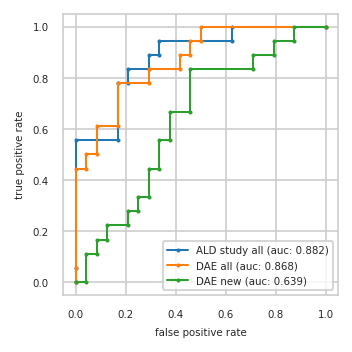

In [21]:
fig, ax = plt.subplots(1, 1, figsize=figsize)
plot_split_auc(results_ald_full.test, results_ald_full.name, ax)
plot_split_auc(results_model_full.test, results_model_full.name, ax)
plot_split_auc(results_model_new.test, results_model_new.name, ax)
fname = args.out_folder / 'auc_roc_curve.pdf'
files_out[fname.name] = fname
pimmslearn.savefig(fig, name=fname)

Data used to plot ROC:

In [22]:
res = [results_ald_full, results_model_full, results_model_new]

auc_roc_curve = parse_roc(*res)
auc_roc_curve.to_excel(fname.with_suffix('.xlsx'))
auc_roc_curve

ALD study all       DAE all       DAE new      
             fpr   tpr     fpr   tpr     fpr   tpr
0          0.000 0.000   0.000 0.000   0.000 0.000
1          0.000 0.056   0.000 0.056   0.042 0.000
2          0.000 0.556   0.000 0.444   0.042 0.111
3          0.167 0.556   0.042 0.444   0.083 0.111
4          0.167 0.778   0.042 0.500   0.083 0.167
5          0.208 0.778   0.083 0.500   0.125 0.167
6          0.208 0.833   0.083 0.611   0.125 0.222
7          0.292 0.833   0.167 0.611   0.208 0.222
8          0.292 0.889   0.167 0.778   0.208 0.278
9          0.333 0.889   0.292 0.778   0.250 0.278
10         0.333 0.944   0.292 0.833   0.250 0.333
11         0.625 0.944   0.417 0.833   0.292 0.333
12         0.625 1.000   0.417 0.889   0.292 0.444
13         1.000 1.000   0.458 0.889   0.333 0.444
14           NaN   NaN   0.458 0.944   0.333 0.556
15           NaN   NaN   0.500 0.944   0.375 0.556
16           NaN   NaN   0.500 1.000   0.375 0.667
17           NaN   NaN   1.000 1.000   0.458 0.667
18           NaN   NaN     NaN   NaN   0.458 0.833
19           NaN   NaN     NaN   NaN   0.708 0.833
20           NaN   NaN     NaN   NaN   0.708 0.889
21           NaN   NaN     NaN   NaN   0.792 0.889
22           NaN   NaN     NaN   NaN   0.792 0.944
23           NaN   NaN     NaN   NaN   0.875 0.944
24           NaN   NaN     NaN   NaN   0.875 1.000
25           NaN   NaN     NaN   NaN   1.000 1.000

### Features selected for final models

In [23]:
selected_features = pd.DataFrame(
    [results_ald_full.selected_features,
     results_model_full.selected_features,
     results_model_new.selected_features],
    index=[
        results_ald_full.name,
        results_model_full.name,
        results_model_new.name]
).T
selected_features.index.name = 'rank'
fname = args.out_folder / 'mrmr_feat_by_model.xlsx'
files_out[fname.name] = fname
selected_features.to_excel(fname)
selected_features

,ALD study all,DAE all,DAE new
rank,,,
0,P04075,P10636-2;P10636-6,Q14894
1,Q9NRN5,Q8NBI6,P51688
2,P09486,P31946;P31946-2,A0A0G2JLL6;A0A1B0GTE9;A0A1B0GTP1;Q7Z6L0;Q7Z6L0...
3,A6NFX8;Q9UKK9,C9JF17;P05090,P31321
4,P10636-2;P10636-6,P61981,F8WBF9;Q5TH30;Q9UGV2;Q9UGV2-2;Q9UGV2-3
5,P14174,Q9Y2T3;Q9Y2T3-3,A6PVN5;F6WIT2;Q15257;Q15257-2;Q15257-3
6,P61981,P04075,A0A0C4DGV4;E9PLX3;O43504;R4GMU8
7,Q9Y2T3;Q9Y2T3-3,P63104,Q9NUQ9
8,P63104,Q14894,Q8TEA8


### Precision-Recall plot on test data

pimmslearn.plotting - INFO     Saved Figures to runs/alzheimer_study/diff_analysis/AD/PI_vs_DAE/prec_recall_curve.pdf


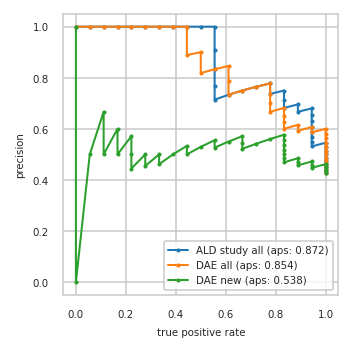

In [24]:
fig, ax = plt.subplots(1, 1, figsize=figsize)

ax = plot_split_prc(results_ald_full.test, results_ald_full.name, ax)
ax = plot_split_prc(results_model_full.test, results_model_full.name, ax)
ax = plot_split_prc(results_model_new.test, results_model_new.name, ax)
fname = folder = args.out_folder / 'prec_recall_curve.pdf'
files_out[fname.name] = fname
pimmslearn.savefig(fig, name=fname)

Data used to plot PRC:

In [25]:
prec_recall_curve = parse_prc(*res)
prec_recall_curve.to_excel(fname.with_suffix('.xlsx'))
prec_recall_curve

ALD study all         DAE all         DAE new      
       precision   tpr precision   tpr precision   tpr
0          0.429 1.000     0.429 1.000     0.429 1.000
1          0.439 1.000     0.439 1.000     0.439 1.000
2          0.450 1.000     0.450 1.000     0.450 1.000
3          0.462 1.000     0.462 1.000     0.462 1.000
4          0.474 1.000     0.474 1.000     0.447 0.944
5          0.486 1.000     0.486 1.000     0.459 0.944
6          0.500 1.000     0.500 1.000     0.472 0.944
7          0.514 1.000     0.514 1.000     0.457 0.889
8          0.529 1.000     0.529 1.000     0.471 0.889
9          0.545 1.000     0.545 1.000     0.485 0.889
10         0.531 0.944     0.562 1.000     0.469 0.833
11         0.548 0.944     0.581 1.000     0.484 0.833
12         0.567 0.944     0.600 1.000     0.500 0.833
13         0.586 0.944     0.586 0.944     0.517 0.833
14         0.607 0.944     0.607 0.944     0.536 0.833
15         0.630 0.944     0.593 0.889     0.556 0.833
16         0.654 0.944     0.615 0.889     0.577 0.833
17         0.680 0.944     0.600 0.833     0.560 0.778
18         0.667 0.889     0.625 0.833     0.542 0.722
19         0.696 0.889     0.652 0.833     0.522 0.667
20         0.682 0.833     0.682 0.833     0.545 0.667
21         0.714 0.833     0.667 0.778     0.571 0.667
22         0.750 0.833     0.700 0.778     0.550 0.611
23         0.737 0.778     0.737 0.778     0.526 0.556
24         0.778 0.778     0.778 0.778     0.556 0.556
25         0.765 0.722     0.765 0.722     0.529 0.500
26         0.750 0.667     0.750 0.667     0.500 0.444
27         0.733 0.611     0.733 0.611     0.533 0.444
28         0.714 0.556     0.786 0.611     0.500 0.389
29         0.769 0.556     0.846 0.611     0.462 0.333
30         0.833 0.556     0.833 0.556     0.500 0.333
31         0.909 0.556     0.818 0.500     0.455 0.278
32         1.000 0.556     0.900 0.500     0.500 0.278
33         1.000 0.500     0.889 0.444     0.444 0.222
34         1.000 0.444     1.000 0.444     0.500 0.222
35         1.000 0.389     1.000 0.389     0.571 0.222
36         1.000 0.333     1.000 0.333     0.500 0.167
37         1.000 0.278     1.000 0.278     0.600 0.167
38         1.000 0.222     1.000 0.222     0.500 0.111
39         1.000 0.167     1.000 0.167     0.667 0.111
40         1.000 0.111     1.000 0.111     0.500 0.056
41         1.000 0.056     1.000 0.056     0.000 0.000
42         1.000 0.000     1.000 0.000     1.000 0.000

## Train data plots

pimmslearn.plotting - INFO     Saved Figures to runs/alzheimer_study/diff_analysis/AD/PI_vs_DAE/prec_recall_curve_train.pdf


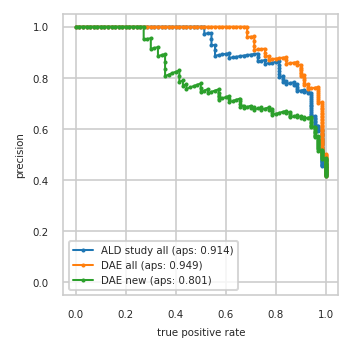

In [26]:
fig, ax = plt.subplots(1, 1, figsize=figsize)

ax = plot_split_prc(results_ald_full.train, results_ald_full.name, ax)
ax = plot_split_prc(results_model_full.train, results_model_full.name, ax)
ax = plot_split_prc(results_model_new.train, results_model_new.name, ax)
fname = folder = args.out_folder / 'prec_recall_curve_train.pdf'
files_out[fname.name] = fname
pimmslearn.savefig(fig, name=fname)

pimmslearn.plotting - INFO     Saved Figures to runs/alzheimer_study/diff_analysis/AD/PI_vs_DAE/auc_roc_curve_train.pdf


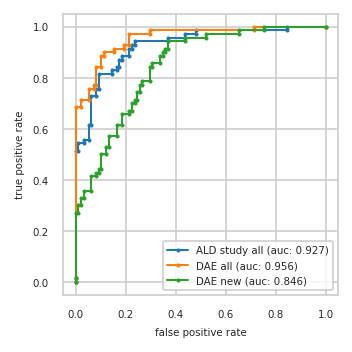

In [27]:
fig, ax = plt.subplots(1, 1, figsize=figsize)
plot_split_auc(results_ald_full.train, results_ald_full.name, ax)
plot_split_auc(results_model_full.train, results_model_full.name, ax)
plot_split_auc(results_model_new.train, results_model_new.name, ax)
fname = folder = args.out_folder / 'auc_roc_curve_train.pdf'
files_out[fname.name] = fname
pimmslearn.savefig(fig, name=fname)

Output files:

In [28]:
files_out

{'results_DAE all.pkl': PosixPath('runs/alzheimer_study/diff_analysis/AD/PI_vs_DAE/results_DAE all.pkl'),
 'results_DAE new.pkl': PosixPath('runs/alzheimer_study/diff_analysis/AD/PI_vs_DAE/results_DAE new.pkl'),
 'results_ALD study all.pkl': PosixPath('runs/alzheimer_study/diff_analysis/AD/PI_vs_DAE/results_ALD study all.pkl'),
 'auc_roc_curve.pdf': PosixPath('runs/alzheimer_study/diff_analysis/AD/PI_vs_DAE/auc_roc_curve.pdf'),
 'mrmr_feat_by_model.xlsx': PosixPath('runs/alzheimer_study/diff_analysis/AD/PI_vs_DAE/mrmr_feat_by_model.xlsx'),
 'prec_recall_curve.pdf': PosixPath('runs/alzheimer_study/diff_analysis/AD/PI_vs_DAE/prec_recall_curve.pdf'),
 'prec_recall_curve_train.pdf': PosixPath('runs/alzheimer_study/diff_analysis/AD/PI_vs_DAE/prec_recall_curve_train.pdf'),
 'auc_roc_curve_train.pdf': PosixPath('runs/alzheimer_study/diff_analysis/AD/PI_vs_DAE/auc_roc_curve_train.pdf')}